In [1]:
import numpy as np

import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.primitives import StatevectorSampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit.visualization import plot_histogram

from qiskit_ibm_runtime import QiskitRuntimeService, Batch, SamplerV2 as Sampler

import time

## 1) Preparation

### 1.1) Parametrization

In [2]:
n_qubits = 10

shots = 1024

token = ""
channel = "ibm_quantum"
instance = "ibm-q/open/main"

### 1.2) Define multiple quantum circuits

In [3]:
def build_qc(n_qubits):
    
    qr = QuantumRegister(n_qubits, "q")
    cr = ClassicalRegister(n_qubits, "c")
    
    qc = QuantumCircuit(qr, cr)
    
    qc.h(0)
    for i in range(n_qubits-1):
        qc.cx(i, i+1)

    qc.barrier()
    
    for i in range(n_qubits):
        qc.measure(i, i)

    return qc

In [8]:
qc = build_qc(n_qubits)

### 1.3) Prepare multiple ISA circuits

In [5]:
service = QiskitRuntimeService(channel=channel, instance=instance)
backend = service.least_busy(operational=True, min_num_qubits=n_qubits)

print(
    f"Name: {backend.name}\n"
    f"Version: {backend.version}\n"
    f"Qubits: {backend.num_qubits}\n"
)

Name: ibm_kyiv
Version: 2
Qubits: 127



In [13]:
target = backend.target
isa_list = []

times = []

for i in range(4):
    time_i = time.time()
    pm = generate_preset_pass_manager(target=target, optimization_level=i)
    isa_list.append(pm.run(qc))
    times.append(time.time() - time_i)

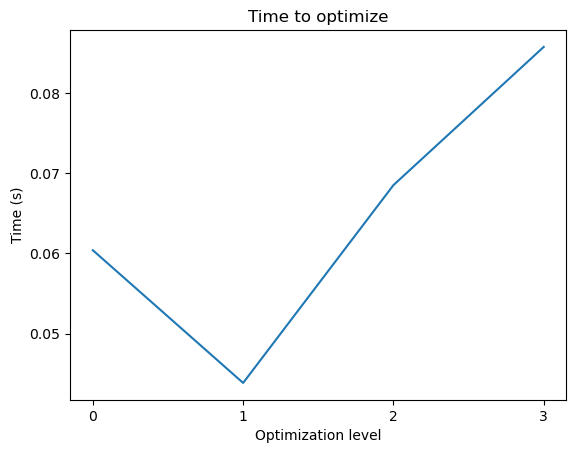

In [18]:
plt.plot(times)

plt.title("Time to optimize")
plt.xticks(range(4))
plt.xlabel("Optimization level")
plt.ylabel("Time (s)")

plt.show()

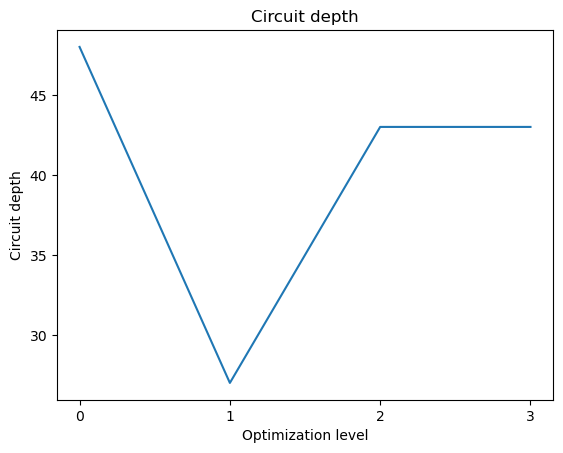

In [29]:
plt.plot([isa_circuit.depth() for isa_circuit in isa_list])

plt.title("Circuit depth")
plt.xticks(range(4))
plt.xlabel("Optimization level")
plt.ylabel("Circuit depth")

plt.show()

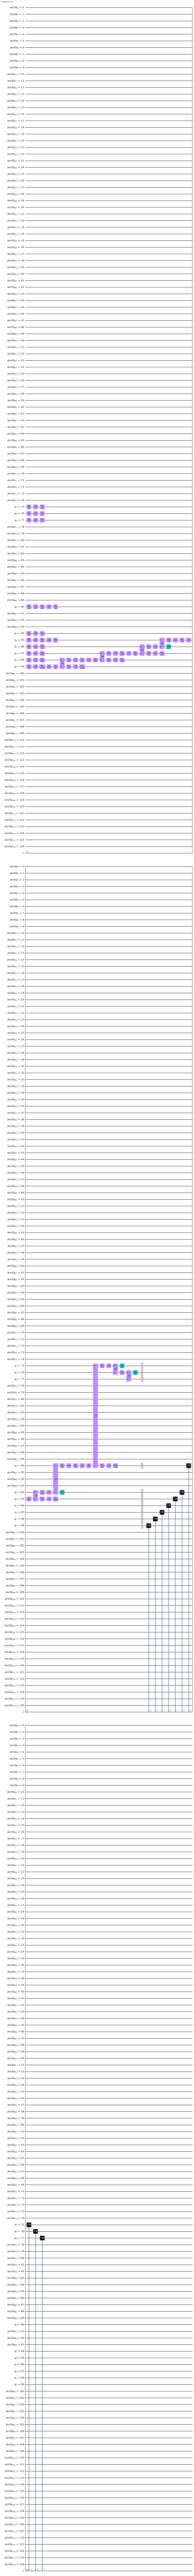

In [33]:
index = 2
isa_list[index].draw("mpl", style="clifford")

## 2) Running all the circuits in one job

In [19]:
sampler = Sampler(backend=backend)

job = sampler.run(isa_list, shots=shots)
job_id = job.job_id()
print("Job ID: ", job_id)

Job ID:  cyt3rb978z600082gj20


## 3) Postprocessing

### 3.1) Retrieving the job from the ID (optional)

In [20]:
job = service.job(job_id)

### 3.2) Post-processing the results

In [21]:
result = job.result()

In [22]:
def get_hist(index):

    try:
        counts = result[index].data.c.array
    except:
        counts = result[index]["__value__"]["data"]["c"].array
    
    hist = {}
    
    for i in range(len(counts)):
    
        x_binary = "".join([bin(counts[i][j])[2:] for j in range(len(counts[i]))]).zfill(index+2)
    
        hist[x_binary] = hist.get(x_binary, 0) + 1
    
    return hist

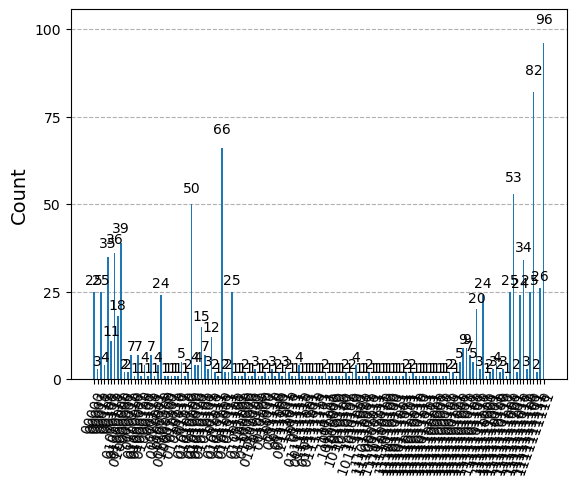

In [37]:
index = 3

hist = get_hist(index)
plot_histogram(hist)

### 3.3) Analyzing the noise level

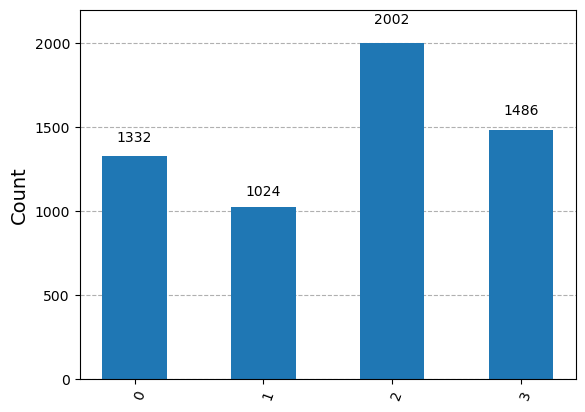

In [27]:
error = {}

for index in range(4):

    hist = get_hist(index)
    n_qubits = len(list(hist.keys())[0])
    
    counts = 0
    for key in hist.keys():

        if key in ("0"*n_qubits, "1"*n_qubits):
            counts += abs(hist[key] - shots//2)

        else:
            counts += hist[key]

    error[index] = counts

plot_histogram(error)